# Model for Recognizing Handwritten Digits

In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub

import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
from keras.utils import np_utils

from tqdm import tqdm

import os
for dirname, _, filenames in os.walk('dataset'): #See all files
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset\emnist-balanced-mapping.txt
dataset\emnist-balanced-test.csv
dataset\emnist-balanced-train.csv
dataset\emnist-byclass-mapping.txt
dataset\emnist-byclass-test.csv
dataset\emnist-byclass-train.csv
dataset\emnist-bymerge-mapping.txt
dataset\emnist-bymerge-test.csv
dataset\emnist-bymerge-train.csv
dataset\emnist-digits-mapping.txt
dataset\emnist-digits-test.csv
dataset\emnist-digits-train.csv
dataset\emnist-letters-mapping.txt
dataset\emnist-letters-test.csv
dataset\emnist-letters-train.csv
dataset\emnist-mnist-mapping.txt
dataset\emnist-mnist-test.csv
dataset\emnist-mnist-train.csv
dataset\emnist_source_files\emnist-balanced-test-images-idx3-ubyte
dataset\emnist_source_files\emnist-balanced-test-labels-idx1-ubyte
dataset\emnist_source_files\emnist-balanced-train-images-idx3-ubyte
dataset\emnist_source_files\emnist-balanced-train-labels-idx1-ubyte
dataset\emnist_source_files\emnist-byclass-test-images-idx3-ubyte
dataset\emnist_source_files\emnist-byclass-test-labels-idx1-ubyte
data

## Part One: Loading the training data

In [3]:
train_df = pd.read_csv('dataset/emnist-balanced-train.csv',
                       header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df.shape

(112800, 785)

### Splitting the data into features and labels

In [5]:
X_train = train_df.loc[:, 1:]
y_train = train_df.loc[:, 0]
X_train.shape, y_train.shape

((112800, 784), (112800,))

In [6]:
X_train.head()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
y_train.head()

0    45
1    36
2    43
3    15
4     4
Name: 0, dtype: int64

### Creating the label dictionary
Maps from outputs to letters

In [8]:
label_map = pd.read_csv("dataset/emnist-balanced-mapping.txt",
                        delimiter=' ',
                        index_col=0,
                        header=None,
                        squeeze=True)
label_map.head()

0
0    48
1    49
2    50
3    51
4    52
Name: 1, dtype: int64

In [9]:
label_dictionary = {}
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

## Part Two: Visualizing the training data

In [10]:
# Sample entry number 42
sample_image = X_train.iloc[42]
sample_label = y_train.iloc[42]
sample_image.shape, sample_label

((784,), 23)

Label entry 42: N


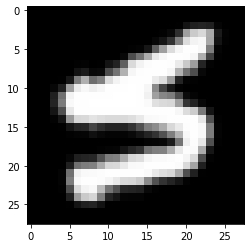

In [11]:
W = 28
H = 28
print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(sample_image.values.reshape(W, H), cmap=plt.cm.gray)
plt.show()

This doesnt look like a N. We probably need to rotate the images.

Label entry 42: N


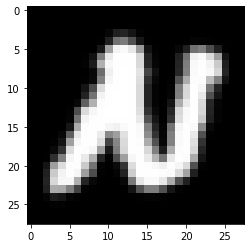

In [12]:
def reshape_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image


print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(reshape_and_rotate(sample_image.values), cmap=plt.cm.gray)
plt.show()

That looks much closer, but maybe this is an outlier? We will need to visualize some other images to check

In [13]:
X_train = np.apply_along_axis(reshape_and_rotate, 1, X_train.values) # X_train is now a numpy array
X_train.shape

(112800, 28, 28)

We visualize some more images to check that rotating was correct

Label entry 42: N


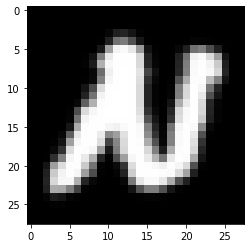

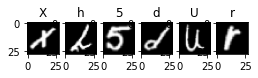

In [14]:
sample_image = X_train[42]
sample_label = y_train.iloc[42]
print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(sample_image.reshape(W, H), cmap=plt.cm.gray)
plt.show()

for i in range(100, 106):
    plt.subplot(390 + (i + 1))
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_train[i]])

Looks good!

### Part Three: Feature Engineering

First we normalize the data to between 0 and 1

In [15]:
X_train = X_train.astype('float32') / 255

One hot encode the labels

In [16]:
number_of_classes = y_train.nunique()
number_of_classes

47

In [17]:
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_train.shape

(112800, 47)

In [18]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Next we reshape the input to fit model

In [19]:
X_train = X_train.reshape(-1, W, H, 1)
X_train.shape

(112800, 28, 28, 1)

Train test split!

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  random_state=88)

## Part Four: Building the model

Here we will finally create our model!

We will start off with a very basic model to ensure everything is working!

In [21]:
model = Sequential()

model.add(keras.layers.Input(shape=(W, H, 1)))
model.add(
    keras.layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        strides=(1, 1),
                        padding="same",
                        activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(
    keras.layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        padding="same",
                        activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(
    keras.layers.Conv2D(filters=64,
                        kernel_size=(3, 3),
                        padding="same",
                        activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(
    keras.layers.Conv2D(filters=128,
                        kernel_size=(3, 3),
                        padding="same",
                        activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1048, activation='swish'))
model.add(keras.layers.Dense(128, activation='swish'))
model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

model.build(input_shape=(None, W, H, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

### Training
Now for the fun part.

We first start off by compiling the model with the Adam optimizer, and set the number of epochs to 10. Then we fit the model and display the accuracies in a graph.

In [21]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
num_epochs = 10
history = model.fit(X_train, y_train,
                    workers=8,
                    epochs=num_epochs,
                    validation_split=0.1,
                    verbose=1)


Epoch 1/10
48/48 [==============================] - 3s 12ms/step - loss: 3.7230 - accuracy: 0.0556 - val_loss: 3.1582 - val_accuracy: 0.1353
Epoch 2/10
48/48 [==============================] - 0s 6ms/step - loss: 2.5222 - accuracy: 0.2660 - val_loss: 1.9642 - val_accuracy: 0.3706
Epoch 3/10
48/48 [==============================] - 0s 6ms/step - loss: 1.6818 - accuracy: 0.4797 - val_loss: 1.5241 - val_accuracy: 0.5235
Epoch 4/10
48/48 [==============================] - 0s 6ms/step - loss: 1.1673 - accuracy: 0.6183 - val_loss: 1.3116 - val_accuracy: 0.5706
Epoch 5/10
48/48 [==============================] - 0s 7ms/step - loss: 0.8530 - accuracy: 0.7118 - val_loss: 1.1493 - val_accuracy: 0.6235
Epoch 6/10
48/48 [==============================] - 0s 7ms/step - loss: 0.6817 - accuracy: 0.7739 - val_loss: 1.1831 - val_accuracy: 0.6176
Epoch 7/10
48/48 [==============================] - 0s 7ms/step - loss: 0.5592 - accuracy: 0.8020 - val_loss: 1.0418 - val_accuracy: 0.6824
Epoch 8/10
48/48 [=

### Visualizing
Here, we will visualize the accuracy of the model as it trains.

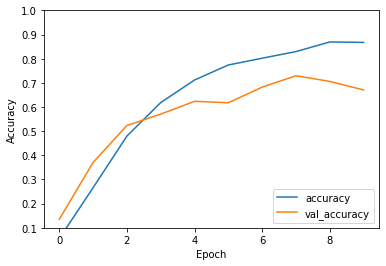

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

Test data
Lets see how well our model does on the test data. 

In [23]:
model.evaluate(X_val, y_val)

10/10 [==============================] - 0s 8ms/step - loss: 1.1715 - accuracy: 0.7033


[1.171479344367981, 0.70333331823349]

In the end, we had a test accuracy of 87.24% Pretty good for a basic model!

## Part Five: Transfer Learning

Here is our real model, we will be using MobileNet for its small size and high accuracy.

Since MobileNet expects three channels, we will convert from grayscale to RGB.

In [21]:
# Convert the one channel numpy array to a 3 channel numpy array
X_train = np.repeat(X_train, 3, axis=3)
X_val = np.repeat(X_val, 3, axis=3)


In [22]:
X_train.shape


(95880, 28, 28, 3)

In [23]:
X_val.shape

(16920, 28, 28, 3)

Next we convert this to a dataset

In [30]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [31]:
train = train.batch(128)
train = train.shuffle(4000)
val = val.batch(128)


In [34]:
model = Sequential()
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
feature_extractor_model = mobilenet_v2

feature_extractor_layer = hub.KerasLayer(feature_extractor_model,
                                         input_shape=(224, 224, 3),
                                         trainable=False)

model.add(keras.layers.Resizing(224, 224))
model.add(feature_extractor_layer)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='swish'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(512, activation='swish'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(256, activation='swish'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

model.build(input_shape=(None, 28, 28, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer_2 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 flatten_2 (Flatten)         (None, 1001)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              1026048   
                                                                 
 batch_normalization_6 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                      

We start training the model with the same parameters as before except with some more epochs and callbacks

In [35]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
num_epochs = 100

lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 patience=4,
                                                 verbose=1,
                                                 factor=0.4,
                                                 min_lr=0.0001)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           min_delta=0.00001,
                                           patience=8,
                                           mode='auto',
                                           restore_best_weights=True)

history = model.fit(
    train,
    epochs=num_epochs,
    validation_data=val,
    verbose=1,
    callbacks=[early_stop, lr_reduction],
)


Epoch 1/100
750/750 [==============================] - 53s 66ms/step - loss: 0.8651 - accuracy: 0.7296 - val_loss: 0.6088 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 2/100
750/750 [==============================] - 50s 66ms/step - loss: 0.5968 - accuracy: 0.7988 - val_loss: 0.5768 - val_accuracy: 0.7951 - lr: 0.0010
Epoch 3/100
750/750 [==============================] - 53s 70ms/step - loss: 0.5371 - accuracy: 0.8173 - val_loss: 0.5411 - val_accuracy: 0.8133 - lr: 0.0010
Epoch 4/100
750/750 [==============================] - 52s 69ms/step - loss: 0.5011 - accuracy: 0.8271 - val_loss: 0.5208 - val_accuracy: 0.8208 - lr: 0.0010
Epoch 5/100
750/750 [==============================] - 55s 73ms/step - loss: 0.4764 - accuracy: 0.8336 - val_loss: 0.5012 - val_accuracy: 0.8216 - lr: 0.0010
Epoch 6/100
750/750 [==============================] - 50s 66ms/step - loss: 0.4564 - accuracy: 0.8397 - val_loss: 0.4940 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 7/100
750/750 [==============================]

## Step Six: Visualizing the model and saving

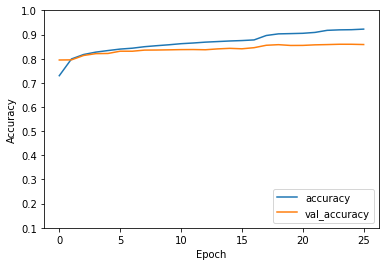

In [36]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

In [37]:
model.save('model.h5')
model.save('model',
              save_format='tf',
                include_optimizer=False,
                signatures=None,
                options=None
)

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
